In [78]:
#================================================================
#Estimating Damage Trends with MSLP
#================================================================

In [79]:
#Importing Packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import preprocessing as pre
import tropycal.tracks as tracks
import tropycal as tc
import datetime
import scipy.stats as stats
import xarray as xr
import geopandas as gpd
import netCDF4
import collections
import netCDF4
import csv
from scipy.stats import poisson
from scipy.stats import pearsonr
from geopy.distance import distance
from geopy import Point
from geopy import distance
import statsmodels.api as sm


pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', None)

In [80]:
#observational data
obs_file_path = "D:\Masters_Thesis\Data_For_Analysis\observations\ibtracs.SI.list.v04r00.csv"

#control_1950
control_file_path = "D:\Masters_Thesis\Data_For_Analysis\control-1950\EC-Earth_Consortium\EC-Earth3p-HR\\r1i1p2f1\TC-SH_TRACK_EC-Earth3P-HR_control-1950_r1i1p2f1_gr_19500101-20491231.nc"

#highres_future
future_file_path = "D:\Masters_Thesis\Data_For_Analysis\highres-future\EC-Earth_Consortium\EC-Earth3p-HR\\r1i1p2f1\TC-SH_TRACK_EC-Earth3P-HR_highres-future_r1i1p2f1_gr_20150101-20501231.nc"

In [81]:
#observational data

hemi = 'SH'
basin = 'si'

#observational data
ibtracs = tracks.TrackDataset(basin='south_indian', source='ibtracs', ibtracs_url=obs_file_path, ibtracs_mode="wmo")
print(ibtracs)

--> Starting to read in ibtracs data
--> Completed reading in ibtracs data (10.86 seconds)
<tropycal.tracks.Dataset>
Dataset Summary:
    Basin:             south_indian
    Source:            ibtracs, wmo
    Number of storms:  1348
    Maximum wind:      153 knots (Fantala 2016)
    Minimum pressure:  895 hPa (Gafilo 2004)
    Year range:        1848 — 2021


In [82]:
#Reading in IBTRaCS data for SWIO region and filter by time period
ibtracs_filter_df = ibtracs.filter_storms(year_range=(1980,2015), date_range=('7/1','6/30'), return_keys=False)



#Reorder columns of filtered dataframe
ibtracs_filter_df.reindex(columns=['season', 'stormid', 'vmax', 'mslp', 'type','lat', 'lon', 'date', 'ace'])


#Adjust date format
ibtracs_filter_df['date'] = pd.to_datetime(ibtracs_filter_df['date'])


bystorm = (ibtracs_filter_df.groupby(['season', 'stormid'], as_index=False)
         .agg(start_date=('date', lambda s: s.min().normalize()),
              end_date=('date', lambda s: s.max().normalize()),
              vmax_max=('vmax', 'max'),
              mslp_max=('mslp', 'min')
             )
         .assign(days=lambda d: d['end_date'].sub(d['start_date']).dt.days,
                 start_year=lambda d: d['start_date'].dt.year,
                 end_year=lambda d: d['end_date'].dt.year)
       )
bystorm = bystorm.rename(columns={'vmax_max': 'vmax'})
bystorm = bystorm.rename(columns={'mslp_max': 'mslp'})





# Rename columns
df1 = bystorm.rename(columns={'days': 'duration'})

#convert knots to m/s
df1['vmax'] = df1['vmax'] * 0.514444

# Drop the start_year and end_year columns
df1 = df1.drop(['start_year', 'end_year'], axis=1)
df1

,season,stormid,start_date,end_date,vmax,mslp,duration
0,1980,1980002S15081,1980-01-02,1980-01-02,16.462208,1000.0,0
1,1980,1980005S11059,1980-01-05,1980-01-05,14.404432,1005.0,0
2,1980,1980009S14066,1980-01-08,1980-01-08,11.317768,1005.0,0
3,1980,1980010S20043,1980-01-12,1980-01-12,16.462208,1000.0,0
4,1980,1980010S22048,1980-01-11,1980-01-11,16.462208,1000.0,0
...,...,...,...,...,...,...,...
364,2015,2015064S14052,2015-03-05,2015-03-11,25.722200,993.0,6
365,2015,2015092S18074,2015-04-02,2015-04-17,43.727740,962.0,15
366,2015,2015094S10087,2015-04-04,2015-04-08,55.045508,953.0,4
367,2016,2015323S05080,2015-11-18,2015-11-27,31.895528,983.0,9


In [83]:
# Get the year of the start_date
df1['year'] = df1['start_date'].dt.year

# Define function to create season range column
def set_season(row):
    if row['start_date'].month >= 10:
        return row['year']
    else:
        return row['year'] - 1


# Apply the function to each row to create a new column
df1['season'] = df1.apply(set_season, axis=1)


# Drop the first four rows of the dataframe
df1 = df1.drop([0, 1, 2, 3, 4, 5, 6, 7])

# Drop the last two rows of the dataframe
df1 = df1.drop(df1.tail(2).index)

#Drop the year column
df1.drop(['year'], axis=1, inplace=True)

print(df1)


     season        stormid start_date   end_date       vmax   mslp  duration
8      1980  1980308S05102 1980-11-03 1980-11-10  61.733280  940.0         7
9      1980  1980348S11116 1980-12-13 1980-12-22  64.305500  940.0         9
10     1980  1981094S06094 1981-04-05 1981-04-15  55.045508  940.0        10
11     1980  1981142S08091 1981-05-24 1981-05-30  37.554412  973.0         6
12     1981  1981306S03096 1981-11-13 1981-11-20  30.866640  976.0         7
..      ...            ...        ...        ...        ...    ...       ...
362    2014  2015036S20038 2015-02-05 2015-02-11  31.895528  978.0         6
363    2014  2015050S11094 2015-02-20 2015-03-01  28.294420  970.0         9
364    2014  2015064S14052 2015-03-05 2015-03-11  25.722200  993.0         6
365    2014  2015092S18074 2015-04-02 2015-04-17  43.727740  962.0        15
366    2014  2015094S10087 2015-04-04 2015-04-08  55.045508  953.0         4

[359 rows x 7 columns]


In [84]:
# Drop rows with NaN values in the vmax column
df1.dropna(subset=['vmax'], inplace=True)
df1
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):

    df1

In [85]:
obs_df = df1


with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(obs_df)

     season        stormid start_date   end_date    vmax    mslp  duration
8      1980  1980308S05102 1980-11-03 1980-11-10  61.733   940.0         7
9      1980  1980348S11116 1980-12-13 1980-12-22  64.305   940.0         9
10     1980  1981094S06094 1981-04-05 1981-04-15  55.046   940.0        10
11     1980  1981142S08091 1981-05-24 1981-05-30  37.554   973.0         6
12     1981  1981306S03096 1981-11-13 1981-11-20  30.867   976.0         7
13     1981  1981351S12060 1981-12-17 1981-12-25  41.156   954.0         8
14     1981  1981363S10079 1981-12-29 1982-01-06  15.433   997.0         8
15     1981  1982005S10105 1982-01-06 1982-01-18  65.334   898.0        12
16     1981  1982030S15065 1982-01-31 1982-02-05  25.722   984.0         5
17     1981  1982031S20048 1982-02-01 1982-02-01  20.578   991.0         0
18     1981  1982036S16060 1982-02-05 1982-02-06  25.722   984.0         1
19     1981  1982043S12073 1982-02-12 1982-02-14  15.433   997.0         2
20     1981  1982054S2305

In [86]:
obs_storms_per_season = obs_df.groupby("season")["stormid"].nunique().reset_index().rename(columns={"stormid": "frequency"})
#obs_storms_per_season["season"] = obs_storms_per_season["season"].str[:4].astype(int)
#obs_storms_per_season["frequency"] = obs_storms_per_season["frequency"].astype(int)
# pandas settings are local to with statement.
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(obs_storms_per_season)

    season  frequency
0     1980          4
1     1981         11
2     1982          7
3     1983         14
4     1984         10
5     1985         12
6     1986          5
7     1987          9
8     1988         12
9     1989          9
10    1990          9
11    1991         15
12    1992         13
13    1993         15
14    1994         13
15    1995         12
16    1996         12
17    1997          8
18    1998          8
19    1999         11
20    2000          8
21    2001         12
22    2002         13
23    2003         10
24    2004         10
25    2005          6
26    2006         11
27    2007         12
28    2008         10
29    2009         10
30    2010          4
31    2011         11
32    2012         10
33    2013         11
34    2014         12


In [87]:
#model storms
from global_land_mask import is_ocean

In [88]:
def normalize_longitude(longitude):
        """
        Normalize the longitude value to be within -180 and 180 degrees.
        """
        while longitude > 180:
            longitude -= 360
        while longitude < -180:
            longitude += 360
        return longitude

def read_storms_filtered(file_path, hemi, basin):
    """
    For a given file path, read the storms from the file.
    """

    # Read the netcdf file
    storms = list(pre.load_cmor(file_path))

    # Check the metadata to discover which algorithm this is, and hence
    # what feature variable is tracked
    with netCDF4.Dataset(file_path, 'r') as nc:
        track_algorithm = nc.getncattr('algorithm')
        if track_algorithm == 'TRACK':
            track_extra = nc.getncattr('algorithm_extra')
            if track_extra == 'T63avg':
                feature_variable = 'vortmean_T63'
            else:
                feature_variable = 'rv850_T42'
        elif track_algorithm == 'TempestExtremes':
            feature_variable = 'psl'
        else:
            raise Exception('Unrecognised algorithm in netcdf file '+file_path)

    if hemi.lower() == 'nh':
        months = pre.months_nh
        lat_min, lat_max, lon_min, lon_max = pre.basin_bounds[basin]
    elif hemi.lower() == 'sh':
        months = pre.months_sh
        lat_min, lat_max, lon_min, lon_max = pre.basin_bounds[basin]
    else:
        raise ValueError('Invalid hemisphere argument. Must be "NH" or "SH"')

    # Filter out storms that do not meet the specified criteria
    filtered_storms = []
    storm_track_points = []  # List to store the storm track points
    for storm in storms:
        # Check if the storm lasted longer than 2 days, check that the 250 hpa and 850 hpa variables are not none, check the difference between 250 hpa and 850 hpa is greater than 0, indicating a warm core
        if storm._storm_vmax_in_basin(basin) and storm.lifetime >= 2 and \
            storm.t63_850_250_diff_max is not None and storm.t63_850_250_diff_max > 0:
            # Normalize the longitude of the first storm track point
            lon = normalize_longitude(storm.obs[0].lon)

           # Check if the normalized longitude and latitude are over the ocean
            if lon <= 180:  # Ensure the longitude is within the valid range
                if is_ocean(storm.obs[0].lat, lon):
                    filtered_storms.append(storm)
                    storm_track_points.extend(storm.obs)

    return filtered_storms, feature_variable, months, storm_track_points


In [89]:
control_filtered_storms, feature_variable, months, storm_track_points = read_storms_filtered(control_file_path,hemi,basin)
print(control_filtered_storms)

fh type <class 'str'>
fname  D:\Masters_Thesis\Data_For_Analysis\control-1950\EC-Earth_Consortium\EC-Earth3p-HR\r1i1p2f1\TC-SH_TRACK_EC-Earth3P-HR_control-1950_r1i1p2f1_gr_19500101-20491231.nc
[<preprocessing.Storm object at 0x000002A08CFBBBB0>, <preprocessing.Storm object at 0x000002A08CFBB700>, <preprocessing.Storm object at 0x000002A08CFBB6A0>, <preprocessing.Storm object at 0x000002A08CFBB4C0>, <preprocessing.Storm object at 0x000002A08CFBB3D0>, <preprocessing.Storm object at 0x000002A08CEB1460>, <preprocessing.Storm object at 0x000002A08CEB1AC0>, <preprocessing.Storm object at 0x000002A08CEB1A00>, <preprocessing.Storm object at 0x000002A08A7EAE20>, <preprocessing.Storm object at 0x000002A08A7EAC10>, <preprocessing.Storm object at 0x000002A08A7EAD00>, <preprocessing.Storm object at 0x000002A08A7EAAC0>, <preprocessing.Storm object at 0x000002A08A7EA400>, <preprocessing.Storm object at 0x000002A08A7EA6D0>, <preprocessing.Storm object at 0x000002A08A7EA040>, <preprocessing.Storm objec

In [90]:
future_filtered_storms, feature_variable, months, storm_track_points = read_storms_filtered(future_file_path,hemi,basin)
print(future_filtered_storms)

fh type <class 'str'>
fname  D:\Masters_Thesis\Data_For_Analysis\highres-future\EC-Earth_Consortium\EC-Earth3p-HR\r1i1p2f1\TC-SH_TRACK_EC-Earth3P-HR_highres-future_r1i1p2f1_gr_20150101-20501231.nc
[<preprocessing.Storm object at 0x000002A08D860C70>, <preprocessing.Storm object at 0x000002A08D860C10>, <preprocessing.Storm object at 0x000002A08D8603A0>, <preprocessing.Storm object at 0x000002A08D860640>, <preprocessing.Storm object at 0x000002A08D8602B0>, <preprocessing.Storm object at 0x000002A08D860550>, <preprocessing.Storm object at 0x000002A08D860A00>, <preprocessing.Storm object at 0x000002A08D860160>, <preprocessing.Storm object at 0x000002A08D860730>, <preprocessing.Storm object at 0x000002A08D8713D0>, <preprocessing.Storm object at 0x000002A08D871E20>, <preprocessing.Storm object at 0x000002A08D871BB0>, <preprocessing.Storm object at 0x000002A08D871070>, <preprocessing.Storm object at 0x000002A08B3AE130>, <preprocessing.Storm object at 0x000002A08D8006D0>, <preprocessing.Storm o

In [91]:
def create_storm_dataframe(storms):
    # Create an empty dictionary to hold the storm data
    storm_data = {"stormid": [], "season":[], "start_date": [], "end_date": [], "duration": [], "vmax": [], "mslp":[]}

    def mslp_max(obs):
        # The maximum central pressure reached by the storm during its lifetime (set to -999 if no records are available) 
        mslps = [ob.mslp for ob in obs if ob.mslp != 1e12]
        if not mslps:
            return -999
        return min(mslps)   

    # Loop over the filtered storms and add the relevant information to the dictionary
    for storm in storms:

        # Determine the start year of the storm
        start_year = storm.genesis_date.year
        # Determine the start month of the storm
        start_month = storm.genesis_date.month
        # Determine the end year of the storm
        end_year = storm.lysis_date.year
        # Determine the end month of the storm
        end_month = storm.lysis_date.month
        
        # Determine the season
        if start_month >= 10 or start_month < 6:
            season = start_year
        else:
            season = start_year - 1
        
        mslp = mslp_max(storm.obs)

        storm_data["stormid"].append(storm.snbr)
        storm_data["season"].append(season)
        storm_data["start_date"].append(storm.genesis_date)
        storm_data["end_date"].append(storm.lysis_date)
        storm_data["duration"].append(storm.lifetime)
        storm_data["vmax"].append(storm.vmax)
        storm_data["mslp"].append(mslp)

    
    
    # Create a DataFrame from the storm data dictionary
    storm_df = pd.DataFrame(storm_data)
    
    return storm_df

In [105]:
#control_1950
control_df = create_storm_dataframe(control_filtered_storms)

start_season = 1980
end_season = 2015

control_df = control_df[(control_df['season'] >= start_season) & (control_df['season'] <= end_season)]

control_df = control_df.drop([355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365])
control_df = control_df.drop(control_df.tail(8).index)

control_df

,stormid,season,start_date,end_date,duration,vmax,mslp
368,1564,1980,1980-10-14 18:00:00,1980-10-30 18:00:00,16,25.036180,1004.119019
369,1565,1980,1980-10-25 00:00:00,1980-11-13 00:00:00,19,22.154181,1006.229980
370,1566,1980,1980-11-09 18:00:00,1980-11-28 18:00:00,19,27.925930,1005.453003
371,1568,1980,1980-11-19 12:00:00,1980-12-17 12:00:00,28,19.798080,1005.041992
372,1570,1980,1980-12-04 00:00:00,1981-01-01 00:00:00,28,26.184690,995.890625
...,...,...,...,...,...,...,...
760,3278,2015,2015-02-09 00:00:00,2015-02-18 00:00:00,9,25.098450,995.438171
761,3282,2015,2015-02-11 12:00:00,2015-03-08 12:00:00,25,45.184559,976.351685
762,3295,2015,2015-03-31 00:00:00,2015-04-22 00:00:00,22,28.896210,999.756592
763,3301,2015,2015-05-04 00:00:00,2015-05-22 00:00:00,18,19.929810,1004.820984


In [93]:
#highres_future
future_df = create_storm_dataframe(future_filtered_storms)
start_season = 2015
end_season = 2050

future_df = future_df[(future_df['season'] >= start_season) & (future_df['season'] <= end_season)]

# Drop the last rows of the dataframe
future_df = future_df.drop([0, 1, 2, 3, 4, 5, 6, 7, 8 ])
future_df = future_df.drop(future_df.tail(2).index)

future_df

,stormid,season,start_date,end_date,duration,vmax,mslp
9,43,2015,2015-10-14 00:00:00,2015-11-11 00:00:00,28,22.630079,1003.612976
10,45,2015,2015-11-17 12:00:00,2015-12-05 12:00:00,18,19.932341,1003.304993
11,49,2016,2016-01-01 00:00:00,2016-01-12 00:00:00,11,23.929560,1000.276978
12,52,2016,2016-01-07 00:00:00,2016-01-14 00:00:00,7,19.241051,1002.245972
13,53,2016,2016-01-14 18:00:00,2016-01-29 18:00:00,15,21.863951,999.861084
...,...,...,...,...,...,...,...
296,1535,2050,2050-01-01 00:00:00,2050-01-13 00:00:00,12,22.858391,1001.216003
297,1544,2050,2050-02-10 18:00:00,2050-02-25 18:00:00,15,27.120300,991.109924
298,1551,2050,2050-03-09 12:00:00,2050-04-08 12:00:00,30,29.413361,996.879700
299,1552,2050,2050-03-12 06:00:00,2050-03-28 06:00:00,16,31.633760,997.377930


In [94]:
obs_df = obs_df.dropna()
control_df = control_df.dropna()
future_df = future_df.dropna()



In [95]:
#Plotting

In [116]:
def plot_regression(x_col, y_col, obs_data, control_data, future_data, x_label, y_label):
    # Create a figure with 3 subplots
    fig, axes = plt.subplots(1,2,figsize=(16, 5), gridspec_kw={'width_ratios': [0.5, 1]})

     # Get the colors from the 'deep' palette
    deep_palette = sns.color_palette()
    obs_color = deep_palette[0]
    control_color = deep_palette[2]
    future_color = deep_palette[1]
    line_color = "black"

    # Create a linear regression plot for each dataset in a different subplot
    sns.regplot(data=obs_data, x=x_col, y=y_col, ax=axes[0], scatter_kws={'color': obs_color}, line_kws={'color': line_color})
    sns.regplot(data=control_data, x=x_col, y=y_col, ax=axes[1],scatter_kws={'color': control_color}, line_kws={'color': line_color})
    sns.regplot(data=future_data, x=x_col, y=y_col, ax=axes[1], scatter_kws={'color': future_color}, line_kws={'color': line_color})
    # Add a vertical line to show the edge of the second plot
    axes[1].axvline(x=obs_data[x_col].max(), linestyle='--', color='gray')

    # Compute and add Pearson correlation coefficients to the plot
    pearson_obs, _ = stats.pearsonr(obs_data[x_col], obs_data[y_col])
    pearson_ctrl, _ = stats.pearsonr(control_data[x_col], control_data[y_col])
    pearson_fut, _ = stats.pearsonr(future_data[x_col], future_data[y_col])

    # Perform linear regression and compute p-values for each dataset
    obs_x = sm.add_constant(obs_data[x_col])
    obs_model = sm.OLS(obs_data[y_col], obs_x).fit()
    obs_p_value = obs_model.pvalues[x_col]

    ctrl_x = sm.add_constant(control_data[x_col])
    ctrl_model = sm.OLS(control_data[y_col], ctrl_x).fit()
    ctrl_p_value = ctrl_model.pvalues[x_col]

    fut_x = sm.add_constant(future_data[x_col])
    fut_model = sm.OLS(future_data[y_col], fut_x).fit()
    fut_p_value = fut_model.pvalues[x_col]

    # Set the titles and Pearson correlation coefficient labels for each subplot
    #axes[0].set_title("Observational 1980-2014")
    #axes[0].annotate("Pearson r = {:.2f}, p-value = {:.4f}".format(pearson_obs, obs_p_value), xy=(0.5, -0.2), xycoords='axes fraction', ha='center')
    #axes[1].set_title("Control 1980-2014 & Future 2015-2050")
    #pearson_str = "Pearson r = {:.2f} & Pearson r = {:.2f}\np-value = {:.3f} & p-value = {:.3f}".format(pearson_ctrl, pearson_fut, ctrl_p_value, fut_p_value)
    #axes[1].annotate(pearson_str, xy=(0.5, -0.2), xycoords='axes fraction', ha='center')
    axes[0].set_title("Observations \n 1980-2014")
    axes[1].set_title("Control - 1950s RF           Future - SSP5-8.5 RF \n 1980 - 2014                      2015 - 2050")

    # Set the x and y axis labels
    axes[0].set_xlabel(x_label)
    axes[0].set_ylabel(y_label)
    axes[1].set_xlabel(x_label)
    axes[1].set_ylabel(y_label)

    # Add a title to the entire figure
    #fig.suptitle("Linear Regression of {} vs {} for Landfall TCs".format(x_label, y_label))

    # Adjust the layout to avoid overlapping titles
    plt.subplots_adjust(top=0.85, hspace=0.2, right=0.9, bottom=0.15)

    # Set all to same scale
    ymin = min(obs_data[y_col].min(), control_data[y_col].min(), future_data[y_col].min())
    ymax = max(obs_data[y_col].max(), control_data[y_col].max(), future_data[y_col].max())
    xmin = min(obs_data[x_col].min(), control_data[x_col].min(), future_data[x_col].min())
    xmax = max(obs_data[x_col].max(), control_data[x_col].max(), future_data[x_col].max())

    # Create the text strings for the correlation coefficients
    ax1textstr = f'Pearson r: {pearson_obs:.4f}'
    ax2textstr = f'Pearson r: {pearson_ctrl:.4f}'
    ax3textstr = f'Pearson r: {pearson_fut:.4f}'

    # Create the text box properties
    props = dict(facecolor='white', alpha=0.5)
    
    # Add the text boxes to the plots
    # Add the text boxes to the plots
    axes[0].annotate(ax1textstr, xy=(0, 1), xycoords='axes fraction', fontsize=12,
                    xytext=(5, -5), textcoords='offset points', ha='left', va='top', bbox=props)
    axes[1].annotate(ax2textstr, xy=(0, 1), xycoords='axes fraction', fontsize=12,
                    xytext=(5, -5), textcoords='offset points', ha='left', va='top', bbox=props)
    axes[1].annotate(ax3textstr, xy=(1, 1), xycoords='axes fraction', fontsize=12,
                    xytext=(-5, -5), textcoords='offset points', ha='right', va='top', bbox=props)

    # Add padding to the y-axis limits
    y_padding = 0.1 * (ymax - ymin)  # Adjust the padding factor as desired
    ymin -= y_padding
    ymax += y_padding

    # Set the same y-axis limits for both subplots
    axes[0].set_ylim([ymin, ymax])
    axes[1].set_ylim([ymin, ymax])

    plt.rcParams.update({'font.size': 14})

    plt.savefig(r'D:\\Masters_Thesis\\Report_Writing\\figures\\linear_regression_{}_{}__mslp.pdf'.format(x_label, y_label.replace('/', '_')), bbox_inches='tight')

    
    print(pearson_obs,
    obs_p_value,
    pearson_ctrl,
    ctrl_p_value,
    pearson_fut,
    fut_p_value)

    # Display the plot
    plt.show()

-0.0700264220131862 0.18618424012185428 0.009581270109350927 0.8490678928114173 -0.07461982618452634 0.20358350289973956


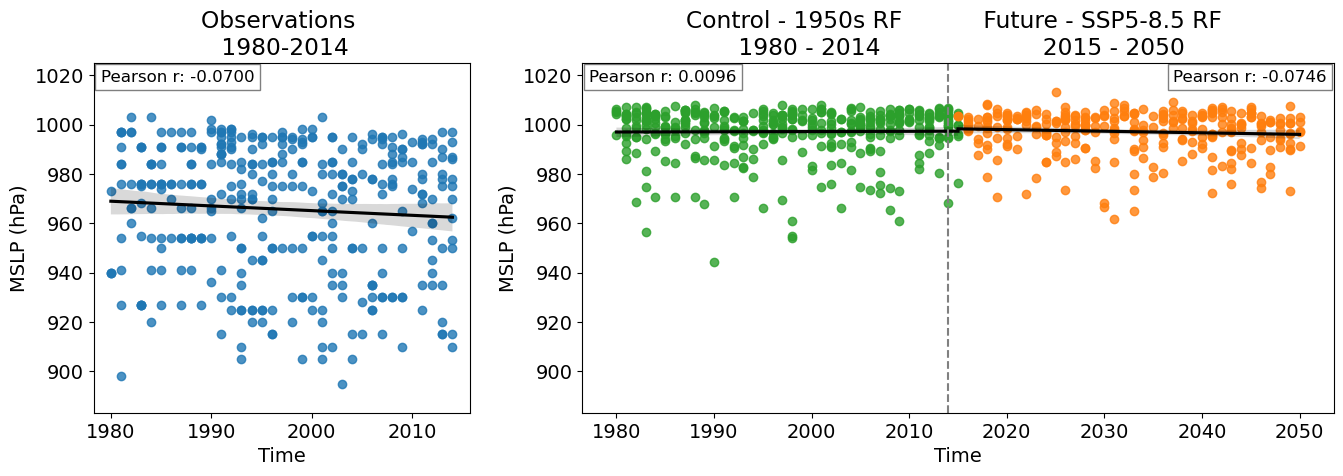

In [117]:
plot_regression("season", "mslp", obs_df, control_df, future_df, "Time", "MSLP (hPa)")

In [98]:
def calculate_and_print_statistics(data, x_col, y_col):
    # Compute Pearson correlation coefficient
    pearson_coef, _ = stats.pearsonr(data[x_col], data[y_col])
    
    # Perform linear regression and compute p-value
    x = sm.add_constant(data[x_col])
    model = sm.OLS(data[y_col], x).fit()
    p_value = model.pvalues[x_col]

    # Round to 4 significant figures
    pearson_coef = round(pearson_coef, 4)
    p_value = round(p_value, 4)
    
    # Print the results
    print(" Pearson correlation coefficient:", pearson_coef)
    print(" Linear regression p-value:", p_value)
    print()

In [99]:
def plot_running_means(x_col, y_col, obs_data, control_data, future_data, x_label, y_label):
    # Define color palette
    colors = sns.color_palette("Set1", 4)
    
    # Create a figure with 3 subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 5), gridspec_kw={'width_ratios': [0.5, 1]})
    
    # Create scatterplots and linear regressions for each dataset in a different subplot
    window_size = 5
    
    # for data below 25th percentile line
    obs_data_below25 = obs_data[obs_data[y_col] < np.percentile(obs_data[y_col], 25)]
    rolling_obs_below25 = obs_data_below25[y_col].rolling(window_size, center=True).mean()
    control_data_below25 = control_data[control_data[y_col] < np.percentile(control_data[y_col], 25)]
    rolling_ctrl_below25 = control_data_below25[y_col].rolling(window_size, center=True).mean()
    future_data_below25 = future_data[future_data[y_col] < np.percentile(future_data[y_col], 25)]
    rolling_fut_below25 = future_data_below25[y_col].rolling(window_size, center=True).mean()

    sns.scatterplot(data=obs_data_below25, x=x_col, y=y_col, alpha=0.5, ax=axes[0], color=colors[1])
    sns.regplot(data=obs_data_below25, x=x_col, y=y_col, scatter=False, ax=axes[0], color=colors[1])
    sns.scatterplot(data=control_data_below25, x=x_col, y=y_col, alpha=0.5, ax=axes[1], color=colors[1])
    sns.regplot(data=control_data_below25, x=x_col, y=y_col, scatter=False, ax=axes[1], color=colors[1])
    sns.scatterplot(data=future_data_below25, x=x_col, y=y_col, alpha=0.5, ax=axes[1], color=colors[1])
    sns.regplot(data=future_data_below25, x=x_col, y=y_col, scatter=False, ax=axes[1], color=colors[1])

    # for data between 25th and 75th percentile lines
    obs_data_25to75 = obs_data[(obs_data[y_col] >= np.percentile(obs_data[y_col], 25)) & 
                               (obs_data[y_col] <= np.percentile(obs_data[y_col], 75))]
    rolling_obs_25to75 = obs_data_25to75[y_col].rolling(window_size, center=True).mean()
    control_data_25to75 = control_data[(control_data[y_col] >= np.percentile(control_data[y_col], 25)) & 
                                       (control_data[y_col] <= np.percentile(control_data[y_col], 75))]
    rolling_ctrl_25to75 = control_data_25to75[y_col].rolling(window_size, center=True).mean()
    future_data_25to75 = future_data[(future_data[y_col] >= np.percentile(future_data[y_col], 25)) & 
                                       (future_data[y_col] <= np.percentile(future_data[y_col], 75))]
    rolling_fut_25to75 = future_data_25to75[y_col].rolling(window_size, center=True).mean()

    sns.scatterplot(data=obs_data_25to75, x=x_col, y=y_col, alpha=0.5, ax=axes[0], color=colors[2])
    sns.regplot(data=obs_data_25to75, x=x_col, y=y_col, scatter=False, ax=axes[0], color=colors[2])
    sns.scatterplot(data=control_data_25to75, x=x_col, y=y_col, alpha=0.5, ax=axes[1], color=colors[2])
    sns.regplot(data=control_data_25to75, x=x_col, y=y_col, scatter=False, ax=axes[1], color=colors[2])
    sns.scatterplot(data=future_data_25to75, x=x_col, y=y_col, alpha=0.5, ax=axes[1], color=colors[2])
    sns.regplot(data=future_data_25to75, x=x_col, y=y_col, scatter=False, ax=axes[1], color=colors[2])
    

    # for data over the 75th percentile line
    
    obs_data_above75 = obs_data[obs_data[y_col] > np.percentile(obs_data[y_col], 75)]
    rolling_obs_above75 = obs_data_above75[y_col].rolling(window_size, center=True).mean()
    control_data_above75 = control_data[control_data[y_col] > np.percentile(control_data[y_col], 75)]
    rolling_ctrl_above75 = control_data_above75[y_col].rolling(window_size, center=True).mean()
    future_data_above75 = future_data[future_data[y_col] > np.percentile(future_data[y_col], 75)]
    rolling_fut_above75 = future_data_above75[y_col].rolling(window_size, center=True).mean()

    sns.scatterplot(data=obs_data_above75, x=x_col, y=y_col, alpha=0.5, ax=axes[0], color=colors[3])
    sns.regplot(data=obs_data_above75, x=x_col, y=y_col, scatter=False, ax=axes[0], color=colors[3])
    sns.scatterplot(data=control_data_above75, x=x_col, y=y_col, alpha=0.5, ax=axes[1], color=colors[3])
    sns.regplot(data=control_data_above75, x=x_col, y=y_col, scatter=False, ax=axes[1], color=colors[3])
    sns.scatterplot(data=future_data_above75, x=x_col, y=y_col, alpha=0.5, ax=axes[1], color=colors[3])
    sns.regplot(data=future_data_above75, x=x_col, y=y_col, scatter=False, ax=axes[1], color=colors[3])

    #Identify percentiles
    obs_data_percentiles = np.percentile(obs_data[y_col], [25, 50, 75])
    control_data_percentiles = np.percentile(control_data[y_col], [25, 50, 75])
    future_data_percentiles = np.percentile(future_data[y_col], [25, 50, 75])

    # Plot dashed percentile lines
    axes[0].hlines(obs_data_percentiles, xmin=obs_data[x_col].min(), xmax=obs_data[x_col].max(),
                linestyles="--", colors="gray", label="25th, 50th, and 75th percentiles")
    axes[1].hlines(control_data_percentiles, xmin=control_data[x_col].min(), xmax=control_data[x_col].max(),
                   linestyles="--", colors="gray", label="25th, 50th, and 75th percentiles")
    axes[1].hlines(future_data_percentiles, xmin=future_data[x_col].min(), xmax=future_data[x_col].max(),
                   linestyles="--", colors="gray")

    # Calculate and print statistics for each dataset and percentile range
    calculate_and_print_statistics(obs_data_below25, x_col, y_col)
    calculate_and_print_statistics(control_data_below25, x_col, y_col)
    calculate_and_print_statistics(future_data_below25, x_col, y_col)
    
    calculate_and_print_statistics(obs_data_25to75, x_col, y_col)
    calculate_and_print_statistics(control_data_25to75, x_col, y_col)
    calculate_and_print_statistics(future_data_25to75, x_col, y_col)
    
    calculate_and_print_statistics(obs_data_above75, x_col, y_col)
    calculate_and_print_statistics(control_data_above75, x_col, y_col)
    calculate_and_print_statistics(future_data_above75, x_col, y_col)

    # Add a vertical line to show the edge of the second plot
    axes[1].axvline(x=obs_data[x_col].max(), linestyle='--', color='gray')
    
    # Add a title to the entire figure
    fig.suptitle(" Linear Regression of {} vs {} for the 25th, 50th, and 75th Percentiles of Landfall Storms".format(x_label, y_label))

    # Adjust the layout to avoid overlapping titles
    plt.subplots_adjust(top=0.85, hspace=0.2, right=0.9)

    ymin = min(obs_data['vmax'].min(), control_data['vmax'].min(), future_data['vmax'].min())
    ymax = max(obs_data['vmax'].max(), control_data['vmax'].max(), future_data['vmax'].max())
    xmin = min(obs_data['season'].min(), control_data['season'].min(), future_data['season'].min())
    xmax = max(obs_data['season'].max(), control_data['season'].max(), future_data['season'].max())

    # Set the x and y axis labels
    axes[0].set_xlabel(x_label)
    axes[0].set_ylabel(y_label)
    axes[1].set_xlabel(x_label)
    axes[1].set_ylabel(y_label)
    
    # Set the titles and Pearson correlation coefficient labels for each subplot
    axes[0].set_title("Observational 1980-2014")
    axes[1].set_title("Control 1980-2014 & Future 2015-2050")
    
   
    plt.savefig('D:\Masters_Thesis\Report Writing\\figures\percentile_regression_{}_{}.pdf'.format(x_label, y_label),bbox_inches='tight')

    # Display the plot
    plt.show()

 Pearson correlation coefficient: -0.1768
 Linear regression p-value: 0.1035

 Pearson correlation coefficient: -0.0422
 Linear regression p-value: 0.675

 Pearson correlation coefficient: 0.032
 Linear regression p-value: 0.7879

 Pearson correlation coefficient: 0.0569
 Linear regression p-value: 0.4358

 Pearson correlation coefficient: 0.0717
 Linear regression p-value: 0.3082

 Pearson correlation coefficient: -0.0988
 Linear regression p-value: 0.2355

 Pearson correlation coefficient: -0.1277
 Linear regression p-value: 0.2528

 Pearson correlation coefficient: 0.0698
 Linear regression p-value: 0.49

 Pearson correlation coefficient: 0.0811
 Linear regression p-value: 0.4949



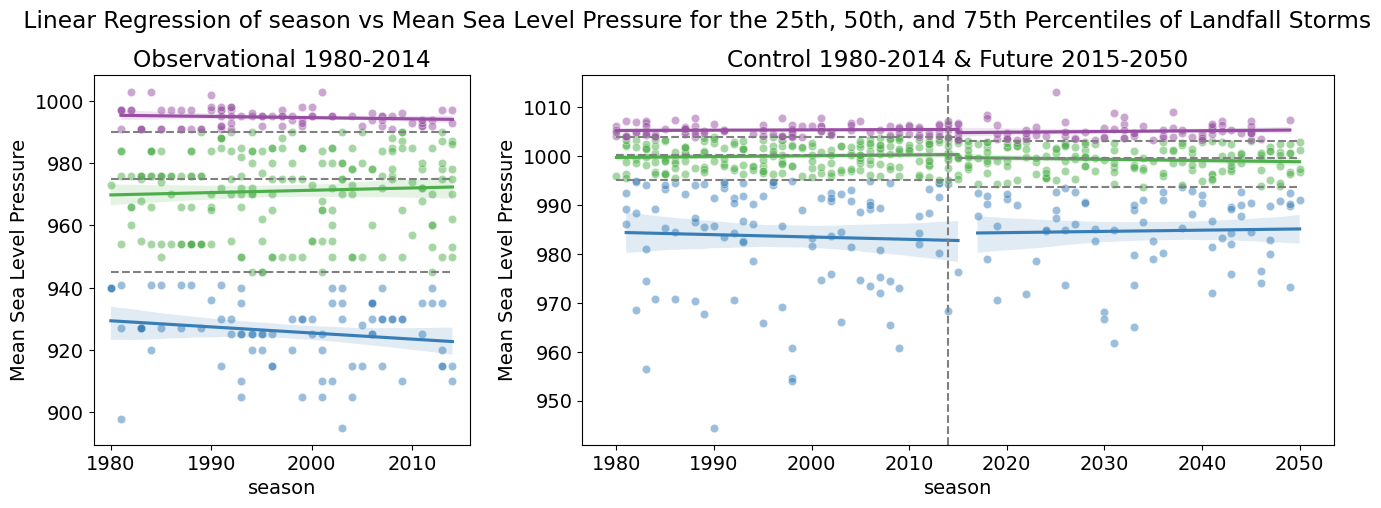

In [100]:
plot_running_means("season","mslp", obs_df, control_df, future_df, "season","Mean Sea Level Pressure")

In [118]:

import scipy.stats as stats

def plot_storms_distribution(x_col, obs_data, control_data, future_data, x_label,binwidth=1):
    # Create a figure with 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))

    deep_palette = sns.color_palette()
    obs_color = deep_palette[0]
    control_color = deep_palette[2]
    future_color = deep_palette[1]
    line_color = deep_palette[7]
    

    # Create a KDE plot for each dataset in a different subplot
    sns.histplot(data=obs_data, x=x_col, binwidth=binwidth, kde=True, ax=axes[0],color=obs_color)
    sns.histplot(data=control_data, x=x_col, binwidth=binwidth, kde=True, ax=axes[1],color=control_color)
    sns.histplot(data=future_data, x=x_col, binwidth=binwidth, kde=True, ax=axes[2],color=future_color)

    # Set the titles for each subplot
    axes[0].set_title("Observations \n 1980-2014")
    axes[1].set_title("Control - 1950s RF \n 1980-2014")
    axes[2].set_title("Future - SSP5-8.5  RF \n 2015-2050")

    # Set a common x-axis label for all subplots
    # fig.text(0.5, 0.04, 'frequency', ha='center')

    # Add a title to the entire figure
    #fig.suptitle("Distribution of {} for Landfall TCs".format(x_label))

    # Adjust the layout to avoid overlapping titles
    plt.subplots_adjust(top=0.85, wspace=0.2)

    # Set the same limits for the x-axis in all subplots
    xmin = min(obs_data[x_col].min(), control_data[x_col].min(), future_data[x_col].min())
    xmax = max(obs_data[x_col].max(), control_data[x_col].max(), future_data[x_col].max())
    for ax in axes:
        ax.set_xlim([xmin, xmax])

    ymin = min([ax.get_ylim()[0] for ax in axes])
    ymax = max([ax.get_ylim()[1] for ax in axes])
    for ax in axes:
        ax.set_ylim([ymin, ymax])

    # Set the x and y axis labels
    axes[0].set_xlabel(x_label)
    axes[1].set_xlabel(x_label)
    axes[2].set_xlabel(x_label)
    

    # Perform the Kruskal-Wallis test and add to the plot
    _, p_value = stats.kruskal(obs_data[x_col], control_data[x_col], future_data[x_col])
    #print("Kruskal-Wallis p-value:", p_value)
    #p_value_str = "Kruskal-Wallis p-value: {}".format(p_value) 
    #axes[1].annotate(p_value_str, xy=(0.5, -0.2), xycoords='axes fraction', ha='center')

    plt.rcParams.update({'font.size': 14})

    # Save figure
    plt.savefig(r'D:\\Masters_Thesis\\Report_Writing\\figures\distribution_{}._mslp.pdf'.format(x_label.replace('/', '_')), bbox_inches='tight')

    print(p_value)

    # Display the plot
    plt.show()

5.842687516723273e-103


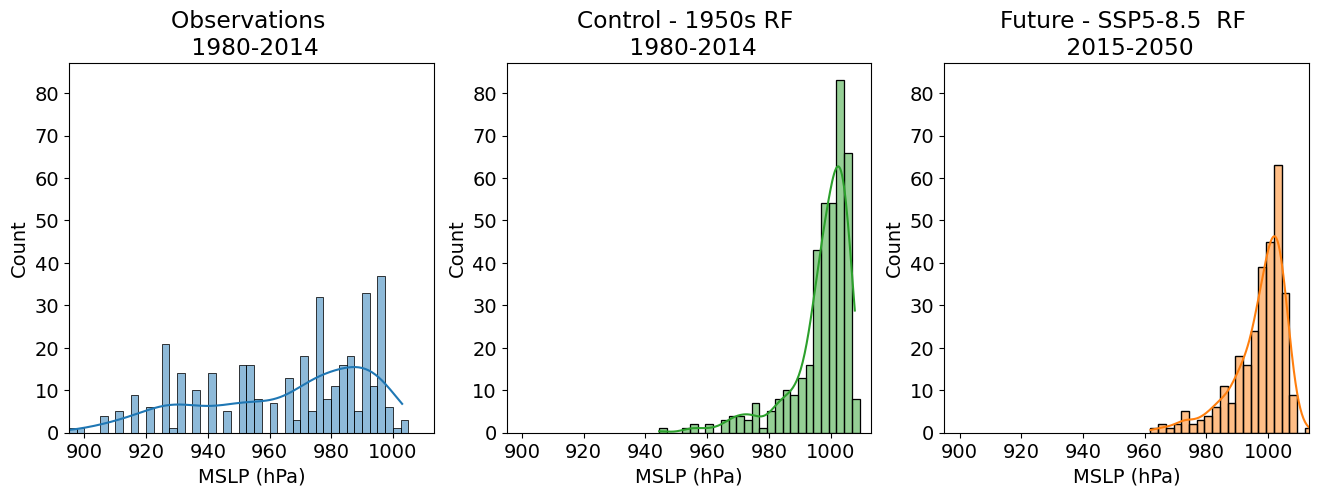

In [119]:
plot_storms_distribution("mslp", obs_df, control_df, future_df, "MSLP (hPa)", binwidth=2.5)

In [109]:
def plot_running_means(x_col, y_col, obs_data, control_data, future_data, x_label, y_label):
    # Define color palette
    colors = sns.color_palette("viridis", 3)

    # Create a figure with 2 subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 5), gridspec_kw={'width_ratios': [0.5, 1]})

    # Create scatterplots and running means for each dataset in a different subplot
    window_size = 5

    # Calculate running mean for each percentile in obs_data
    obs_percentiles = np.percentile(obs_data[y_col], [25, 50, 75])
    obs_running_means = [obs_data[obs_data[y_col] <= p][y_col].rolling(window_size, center=True).mean()
                         for p in obs_percentiles]

    # Plot running means for each percentile in obs_data
    for i, running_mean in enumerate(obs_running_means):
        sns.lineplot(data=running_mean, x=obs_data[x_col], y=running_mean, ax=axes[0], color=colors[i], ci=None)

    # Calculate running mean for each percentile in control_data
    control_percentiles = np.percentile(control_data[y_col], [25, 50, 75])
    control_running_means = [control_data[control_data[y_col] <= p][y_col].rolling(window_size, center=True).mean()
                             for p in control_percentiles]

    # Plot running means for each percentile in control_data
    for i, running_mean in enumerate(control_running_means):
        sns.lineplot(data=running_mean, x=control_data[x_col], y=running_mean, ax=axes[1], color=colors[i], ci=None)

    # Calculate running mean for each percentile in future_data
    future_percentiles = np.percentile(future_data[y_col], [25, 50, 75])
    future_running_means = [future_data[future_data[y_col] <= p][y_col].rolling(window_size, center=True).mean()
                            for p in future_percentiles]

    # Plot running means for each percentile in future_data
    for i, running_mean in enumerate(future_running_means):
        sns.lineplot(data=running_mean, x=future_data[x_col], y=running_mean, ax=axes[1], color=colors[i], ci=None)

    # Add a vertical line to show the edge of the second plot
    axes[1].axvline(x=obs_data[x_col].max(),linestyle='--', color='gray')

    # Add a title to the entire figure
    #fig.suptitle("5-year running means of {} vs {} for the 25th, 50th, and 75th percentile".format(x_label, y_label))

    # Adjust the layout to avoid overlapping titles
    plt.subplots_adjust(top=0.85, hspace=0.2, right=0.9)

    # Determine y-axis limits for both subplots
    ymin = min([running_mean.min() for running_mean in obs_running_means +
                control_running_means + future_running_means])
    ymax = max([running_mean.max() for running_mean in obs_running_means +
                control_running_means + future_running_means])

    # Set the same y-axis limits for both subplots
    axes[0].set_ylim([ymin, ymax])
    axes[1].set_ylim([ymin, ymax])

    
    # Add a legend for the observational dataset
    legend_labels = ['25th Percentile', '50th Percentile', '75th Percentile']
    legend_colors = [colors[0], colors[1], colors[2]]  # Corresponding colors for the legend labels
    axes[0].legend(labels=legend_labels, handles=[plt.Line2D([0], [0], color=c, linestyle='-') for c in legend_colors])

    # Add gridlines to both subplots
    axes[0].grid(True)
    axes[1].grid(True)

    # Set the x and y axis labels
    axes[0].set_xlabel(x_label)
    axes[0].set_ylabel(y_label)
    axes[1].set_xlabel(x_label)
    axes[1].set_ylabel(y_label)

    # Set the titles for each subplot
    axes[0].set_title("Observations \n 1980-2014")
    axes[1].set_title("Control - 1950s RF           Future - SSP5-8.5 RF \n 1980 - 2014                      2015 - 2050")

    plt.rcParams.update({'font.size': 14})

    plt.savefig(r'D:\\Masters_Thesis\\Report_Writing\\figures\percentile_{}_{}_mslp.pdf'.format(x_label, y_label.replace('/', '_')), bbox_inches='tight')


    # Display the plot
    plt.show()

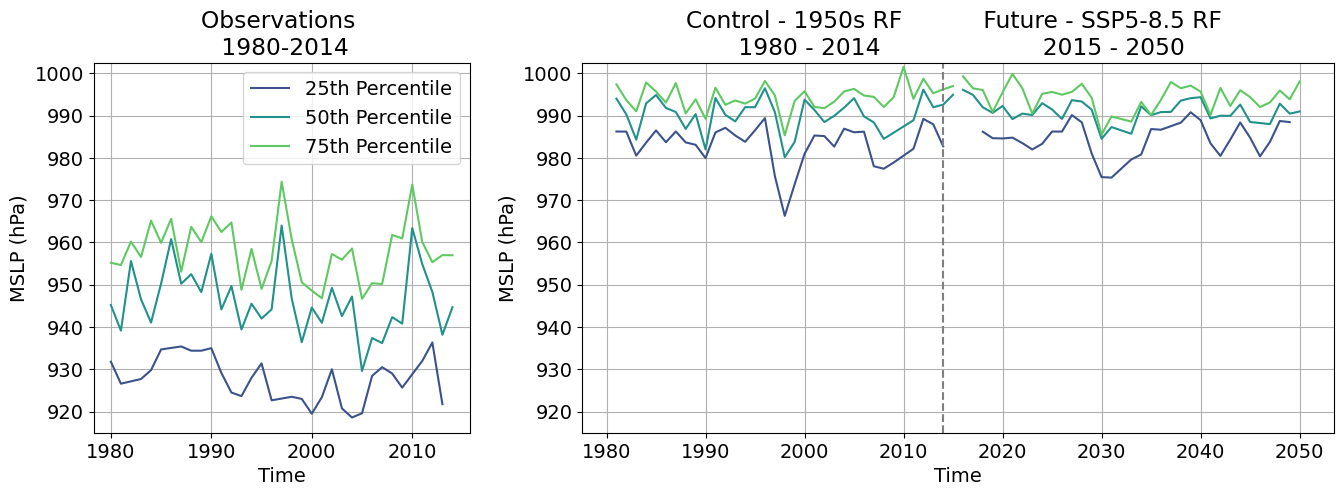

In [111]:
plot_running_means("season", "mslp", obs_df, control_df, future_df, "Time", "MSLP (hPa)")